# Two-Layer Synthetic Causal Simulation (Known Hierarchy)

This tutorial demonstrates how to:

- Load (or optionally generate) a synthetic two-layer dataset
- Run CauTrigger in a known hierarchical setting (Layer 1 → Layer 2)
- Visualize causal vs spurious latent spaces
- Examine information flow across layers

## 1. Global setup and imports

In [1]:
import os
import sys
import math
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scanpy as sc
import gc

from scipy.stats import ttest_ind
from anndata import AnnData
from matplotlib.patches import Ellipse

from cautrigger.utils import set_seed
from cautrigger.model import CauTrigger2L, CauTrigger1L
from cautrigger.dataloaders import generate_two_layer_synthetic_data

sns.set_theme(style="white")
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib.font_manager').disabled = True

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'


## 2. Paths and configuration

In [2]:
# Root directories
base_dir = "../../02_simulation"
data_root = os.path.join(base_dir, "data")
out_root = os.path.join(base_dir, "output")

case_name = "2L_known_semi_hrc_hidden10_linear_cs40_p0.5_sc"
data_dir = os.path.join(data_root, case_name, 'dataset1')
output_dir = os.path.join(out_root, 'two_layer_known')

os.makedirs(output_dir, exist_ok=True)

np.random.seed(42)
set_seed(42)

adata_path = os.path.join(data_dir, "adata.h5ad")


## 3. Load (or optionally generate) synthetic dataset

In [3]:
generate_data = False  # set True to regenerate

if generate_data:
    generation_args = dict(
        spurious_mode='semi_hrc',
        n_hidden=10,
        activation='linear',
        causal_strength=0.4,
        p_zero=0.5,
        simulate_single_cell=True,
    )
    adata = generate_two_layer_synthetic_data(seed=42, **generation_args)
else:
    adata = sc.read_h5ad(adata_path)

print(adata)
print(adata.var["layer"].value_counts())


AnnData object with n_obs × n_vars = 200 × 150
    obs: 'labels'
    var: 'feat_type', 'layer', 'is_causal'
    obsm: 'layer1', 'layer2'
layer
layer1    100
layer2     50
Name: count, dtype: int64


## 4. Train CauTrigger on Layer 1

training: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.65it/s]


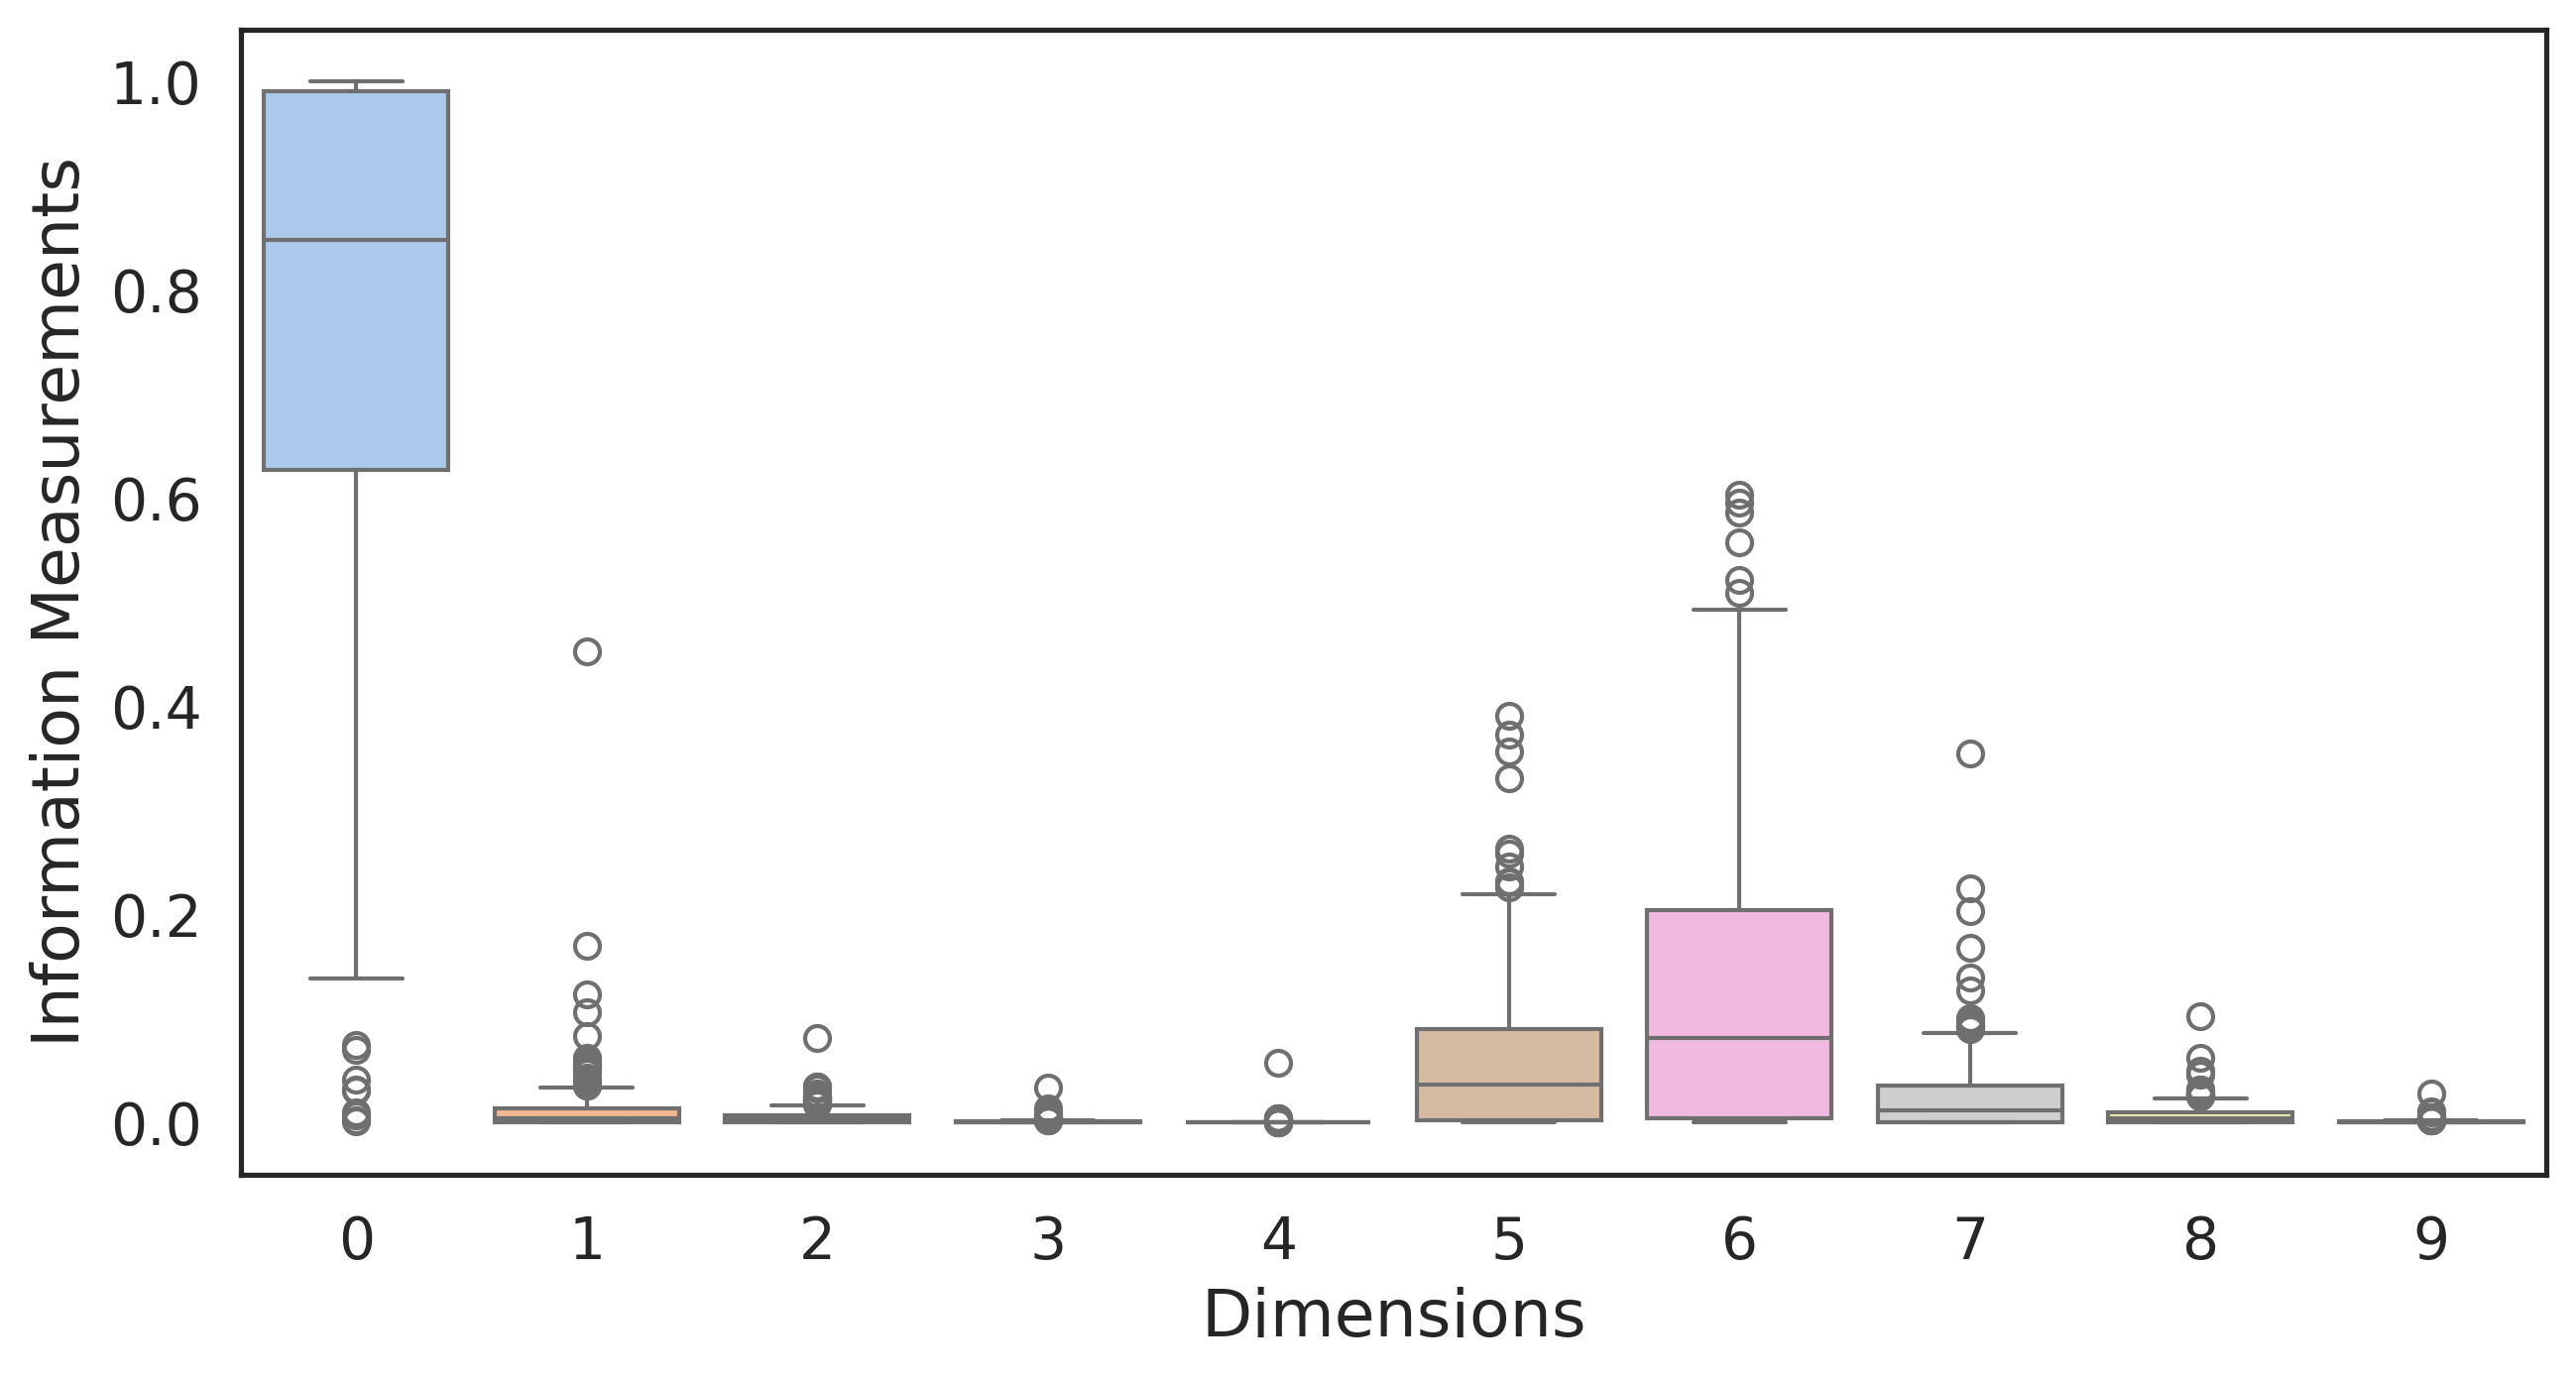

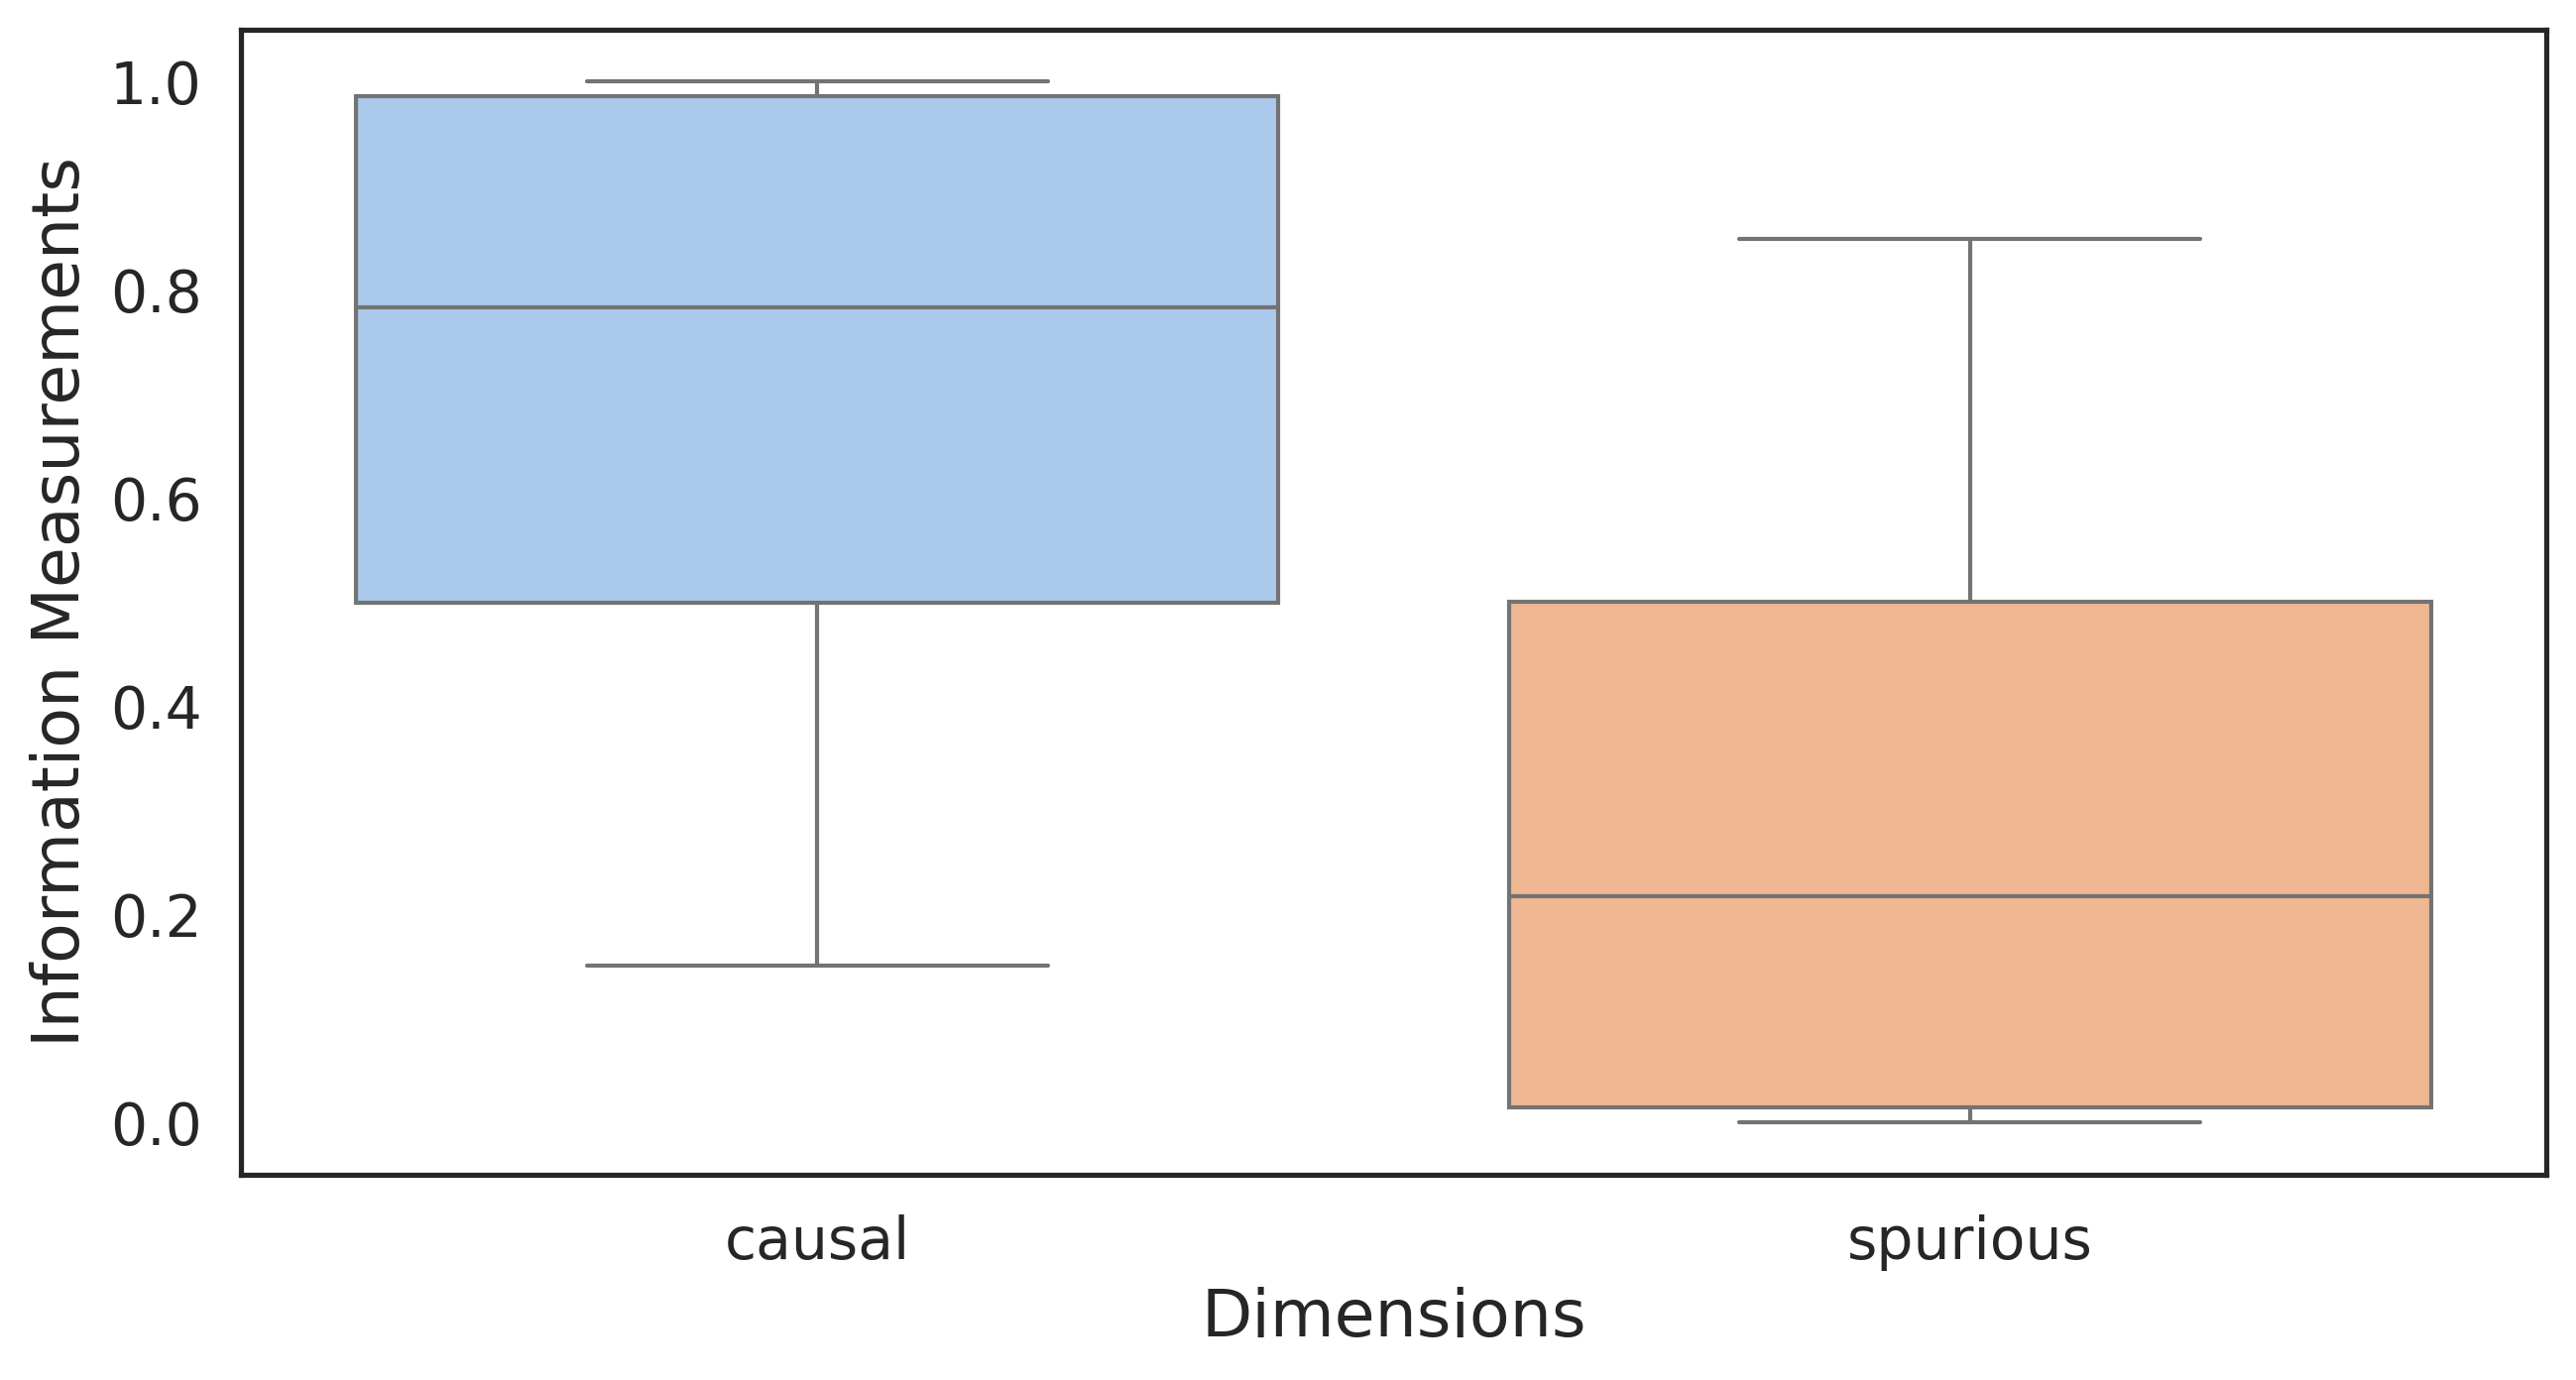

(            0         1         2         3         4         5         6  \
 0    0.523847  0.006137  0.004729  0.000408  0.000170  0.182491  0.245564   
 1    0.740391  0.003828  0.005954  0.000753  0.000075  0.066525  0.156985   
 2    0.710571  0.009342  0.003520  0.000502  0.000051  0.073055  0.179951   
 3    0.798089  0.003373  0.002880  0.000330  0.000043  0.035886  0.145742   
 4    0.932918  0.000389  0.000574  0.000045  0.000014  0.016412  0.045849   
 ..        ...       ...       ...       ...       ...       ...       ...   
 195  0.981886  0.002246  0.000405  0.000099  0.000111  0.005186  0.007248   
 196  0.710309  0.009786  0.005422  0.001209  0.000264  0.068652  0.138121   
 197  0.920478  0.002920  0.001324  0.000187  0.000067  0.026001  0.037630   
 198  0.661235  0.017686  0.010498  0.001150  0.000336  0.088575  0.186522   
 199  0.214908  0.055392  0.018668  0.004176  0.001534  0.258732  0.322838   
 
             7         8         9  
 0    0.025873  0.010042 

In [4]:
layer1_vars = adata.var_names[adata.var["layer"] == "layer1"]
adata_step1 = sc.AnnData(
    X=adata.obsm["layer1"],
    obs=adata.obs.copy(),
    var=adata.var.loc[layer1_vars].copy()
)

model_1L = CauTrigger1L(
    adata_step1,
    n_causal=2,
    n_latent=10,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=True,
    init_thresh=0.4,
)

model_1L.train(max_epochs=200, stage_training=True, weight_scheme="sim")
df_step1, _ = model_1L.get_up_feature_weights(method='SHAP', normalize=False, sort_by_weight=True)
model_1L.compute_information_flow(save_fig=True, skip_single_info=False, save_dir=output_dir)


### Layer 1 latent space visualization

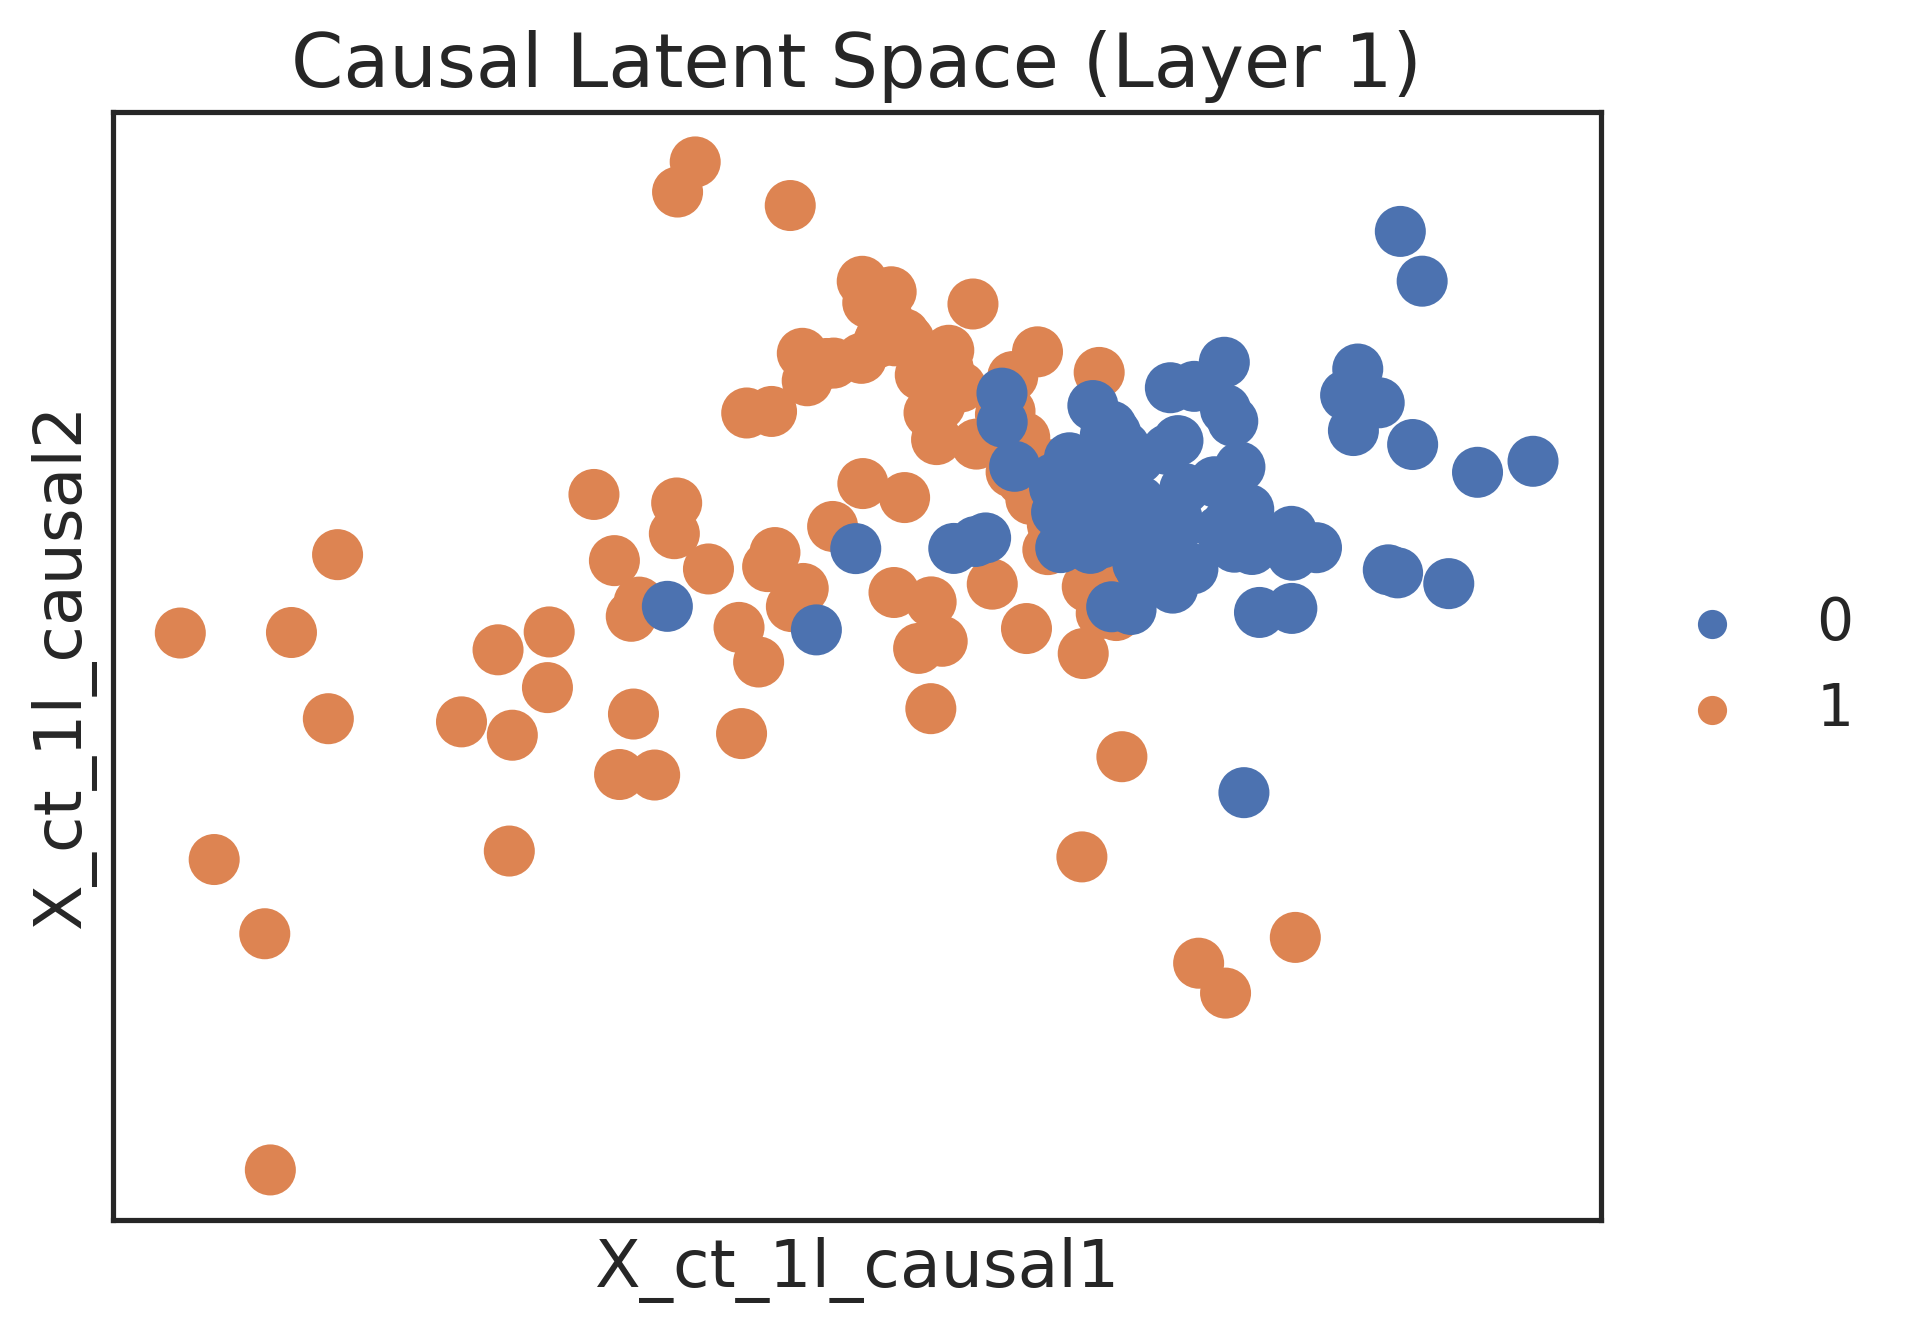

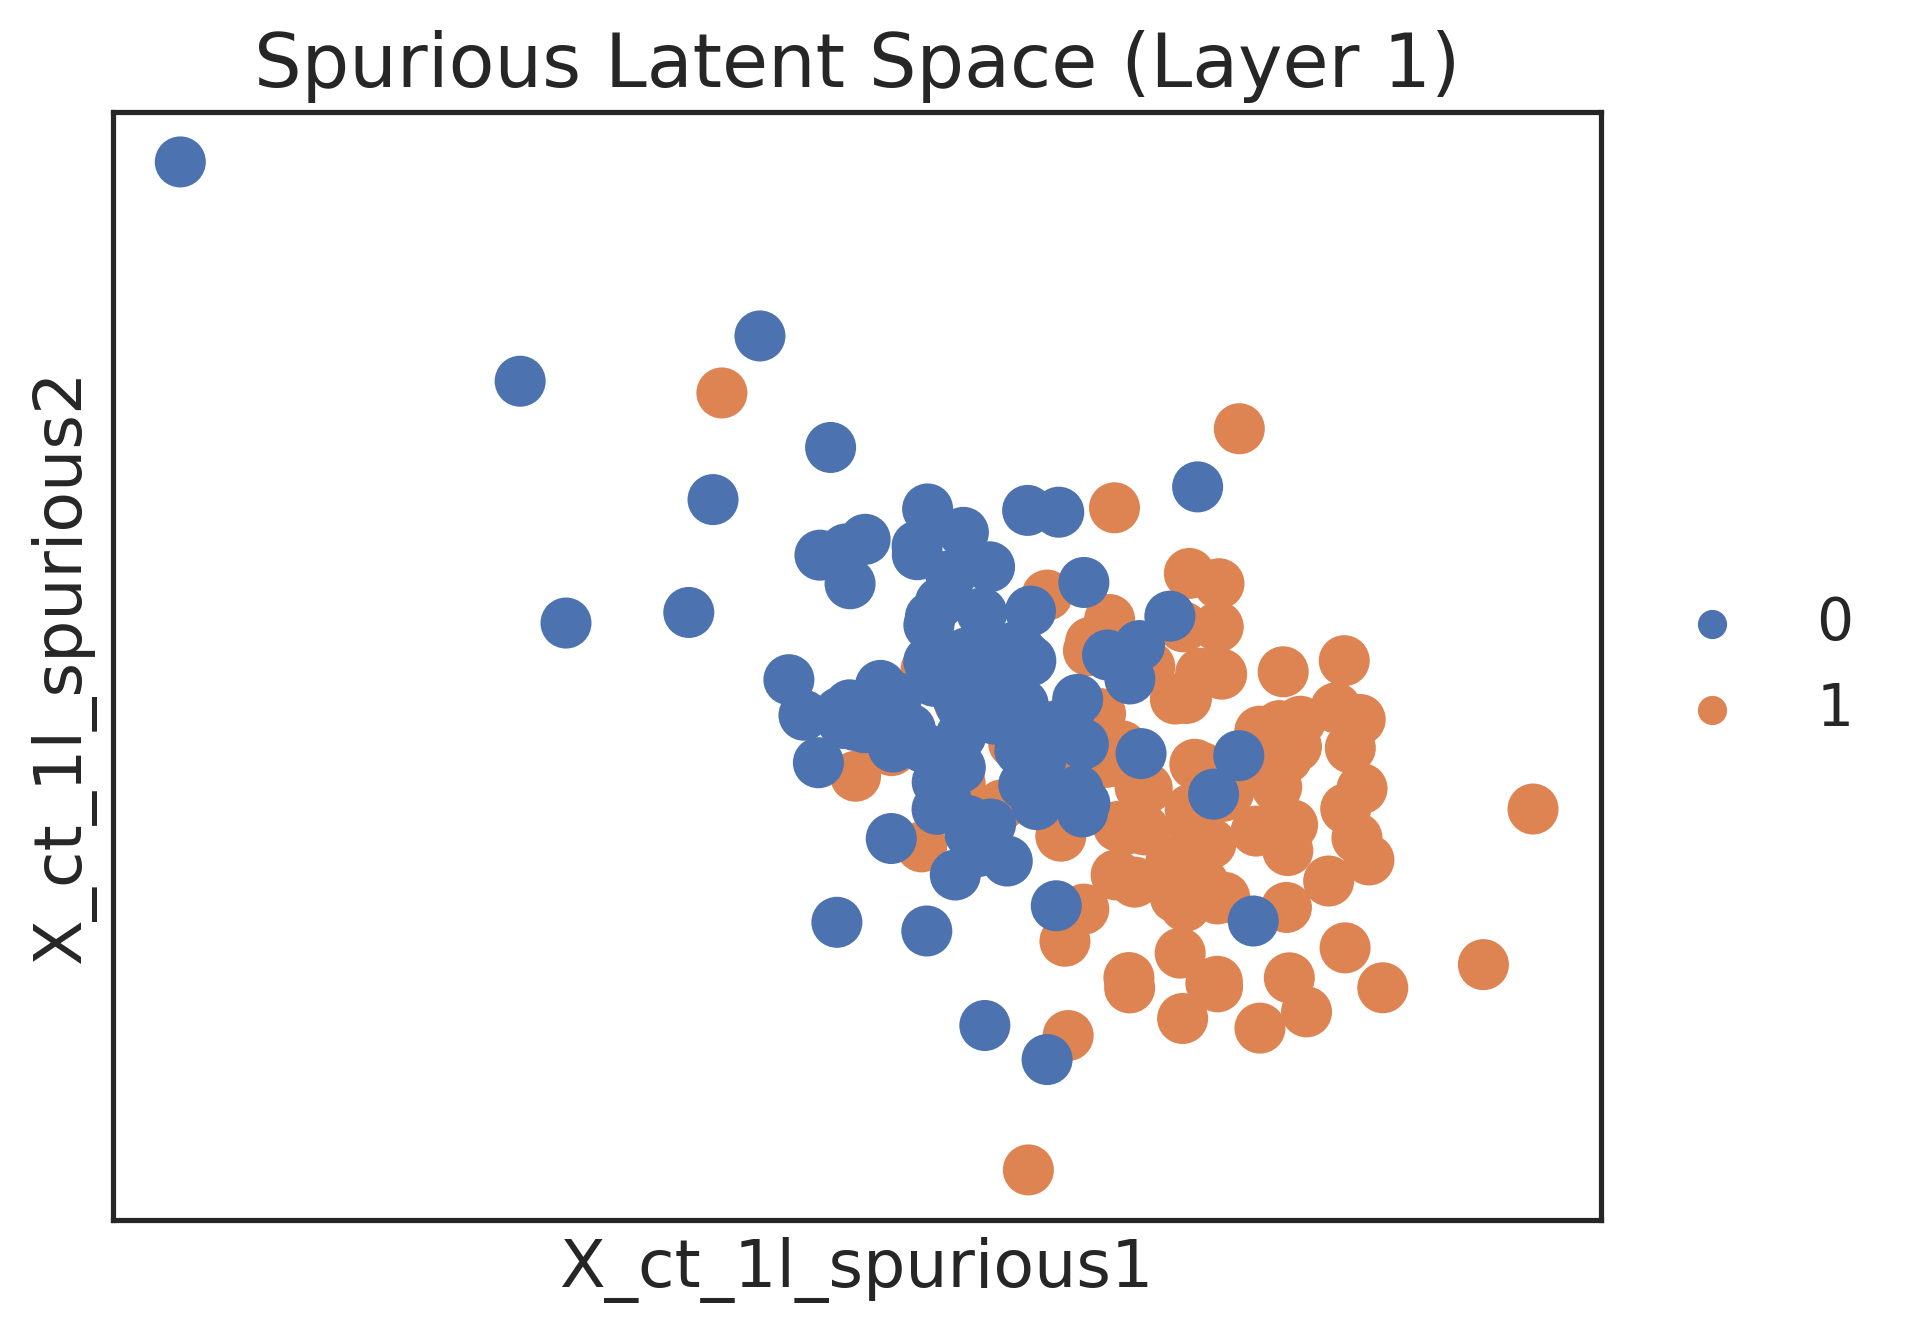

In [5]:
adata_step1.obsm['X_ct_1l_causal'] = model_1L.get_model_output()['latent'][:, :2]
adata_step1.obsm['X_ct_1l_spurious'] = model_1L.get_model_output()['latent'][:, -2:]
adata_step1.obs.labels = adata_step1.obs['labels'].astype(str)

sc.pl.embedding(
    adata_step1, basis='X_ct_1l_causal', color='labels',
    title='Causal Latent Space (Layer 1)', show=True
)

sc.pl.embedding(
    adata_step1, basis='X_ct_1l_spurious', color='labels',
    title='Spurious Latent Space (Layer 1)', show=True
)


## 5. Train CauTrigger on Layer 2 with top features

training: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:21<00:00,  9.22it/s]


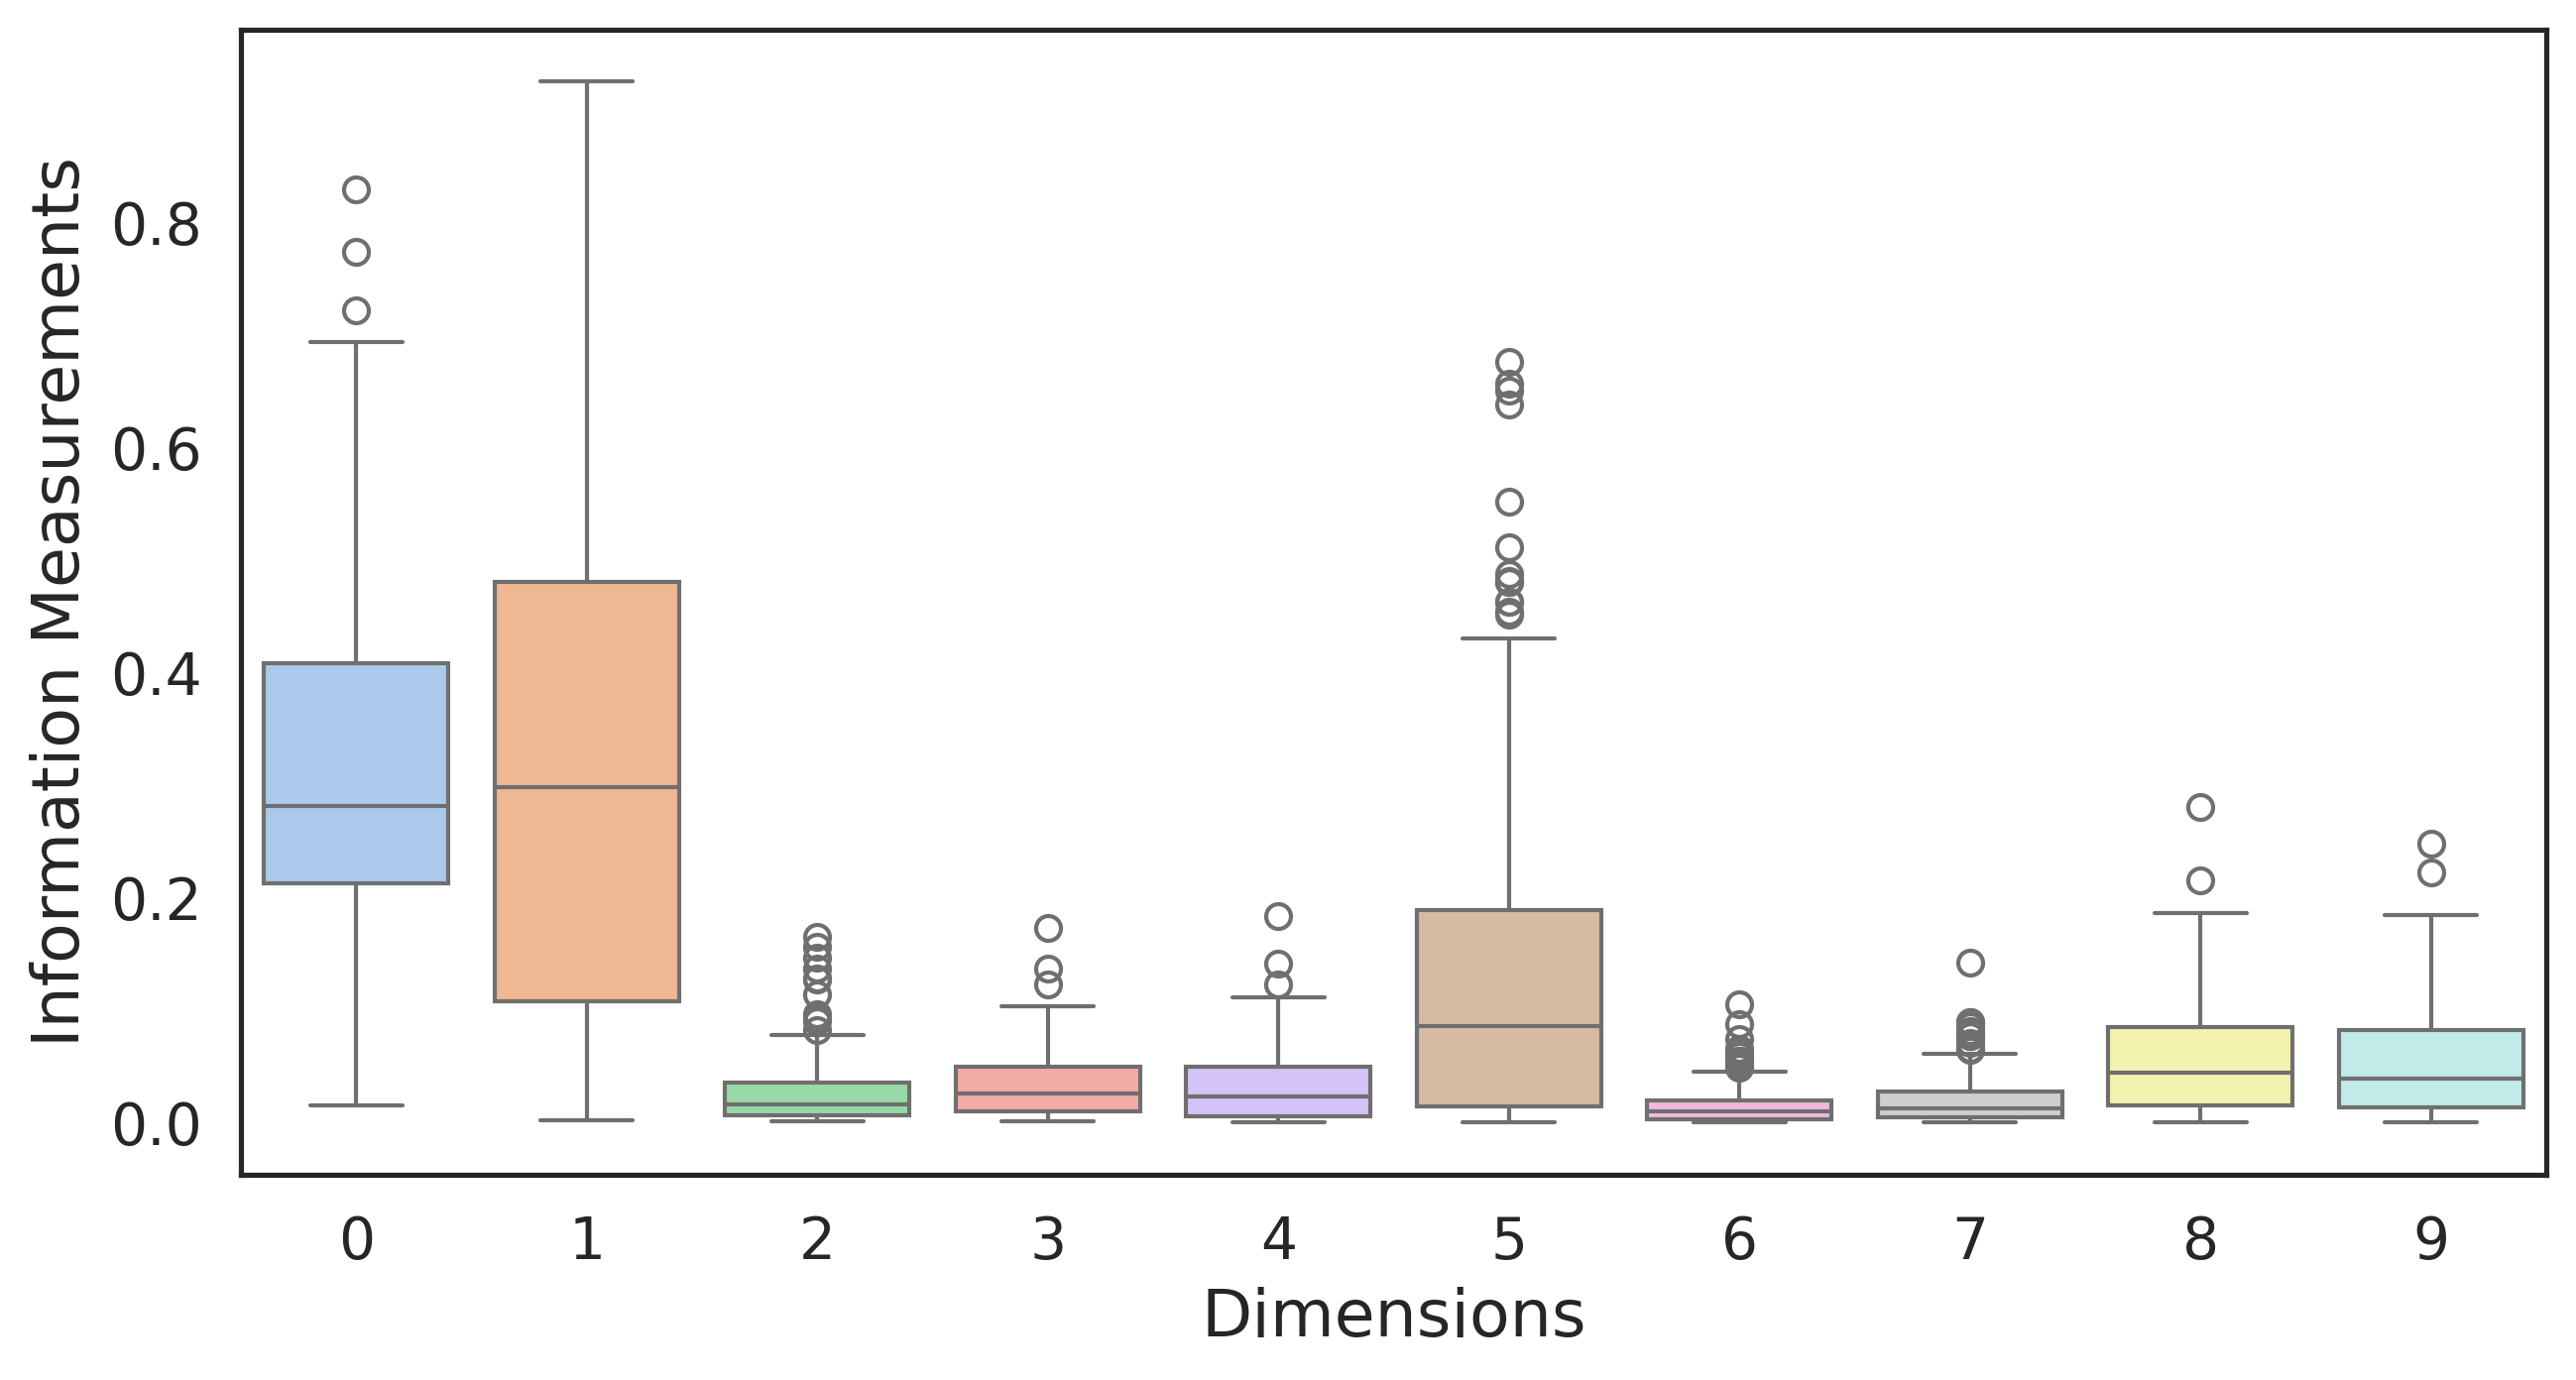

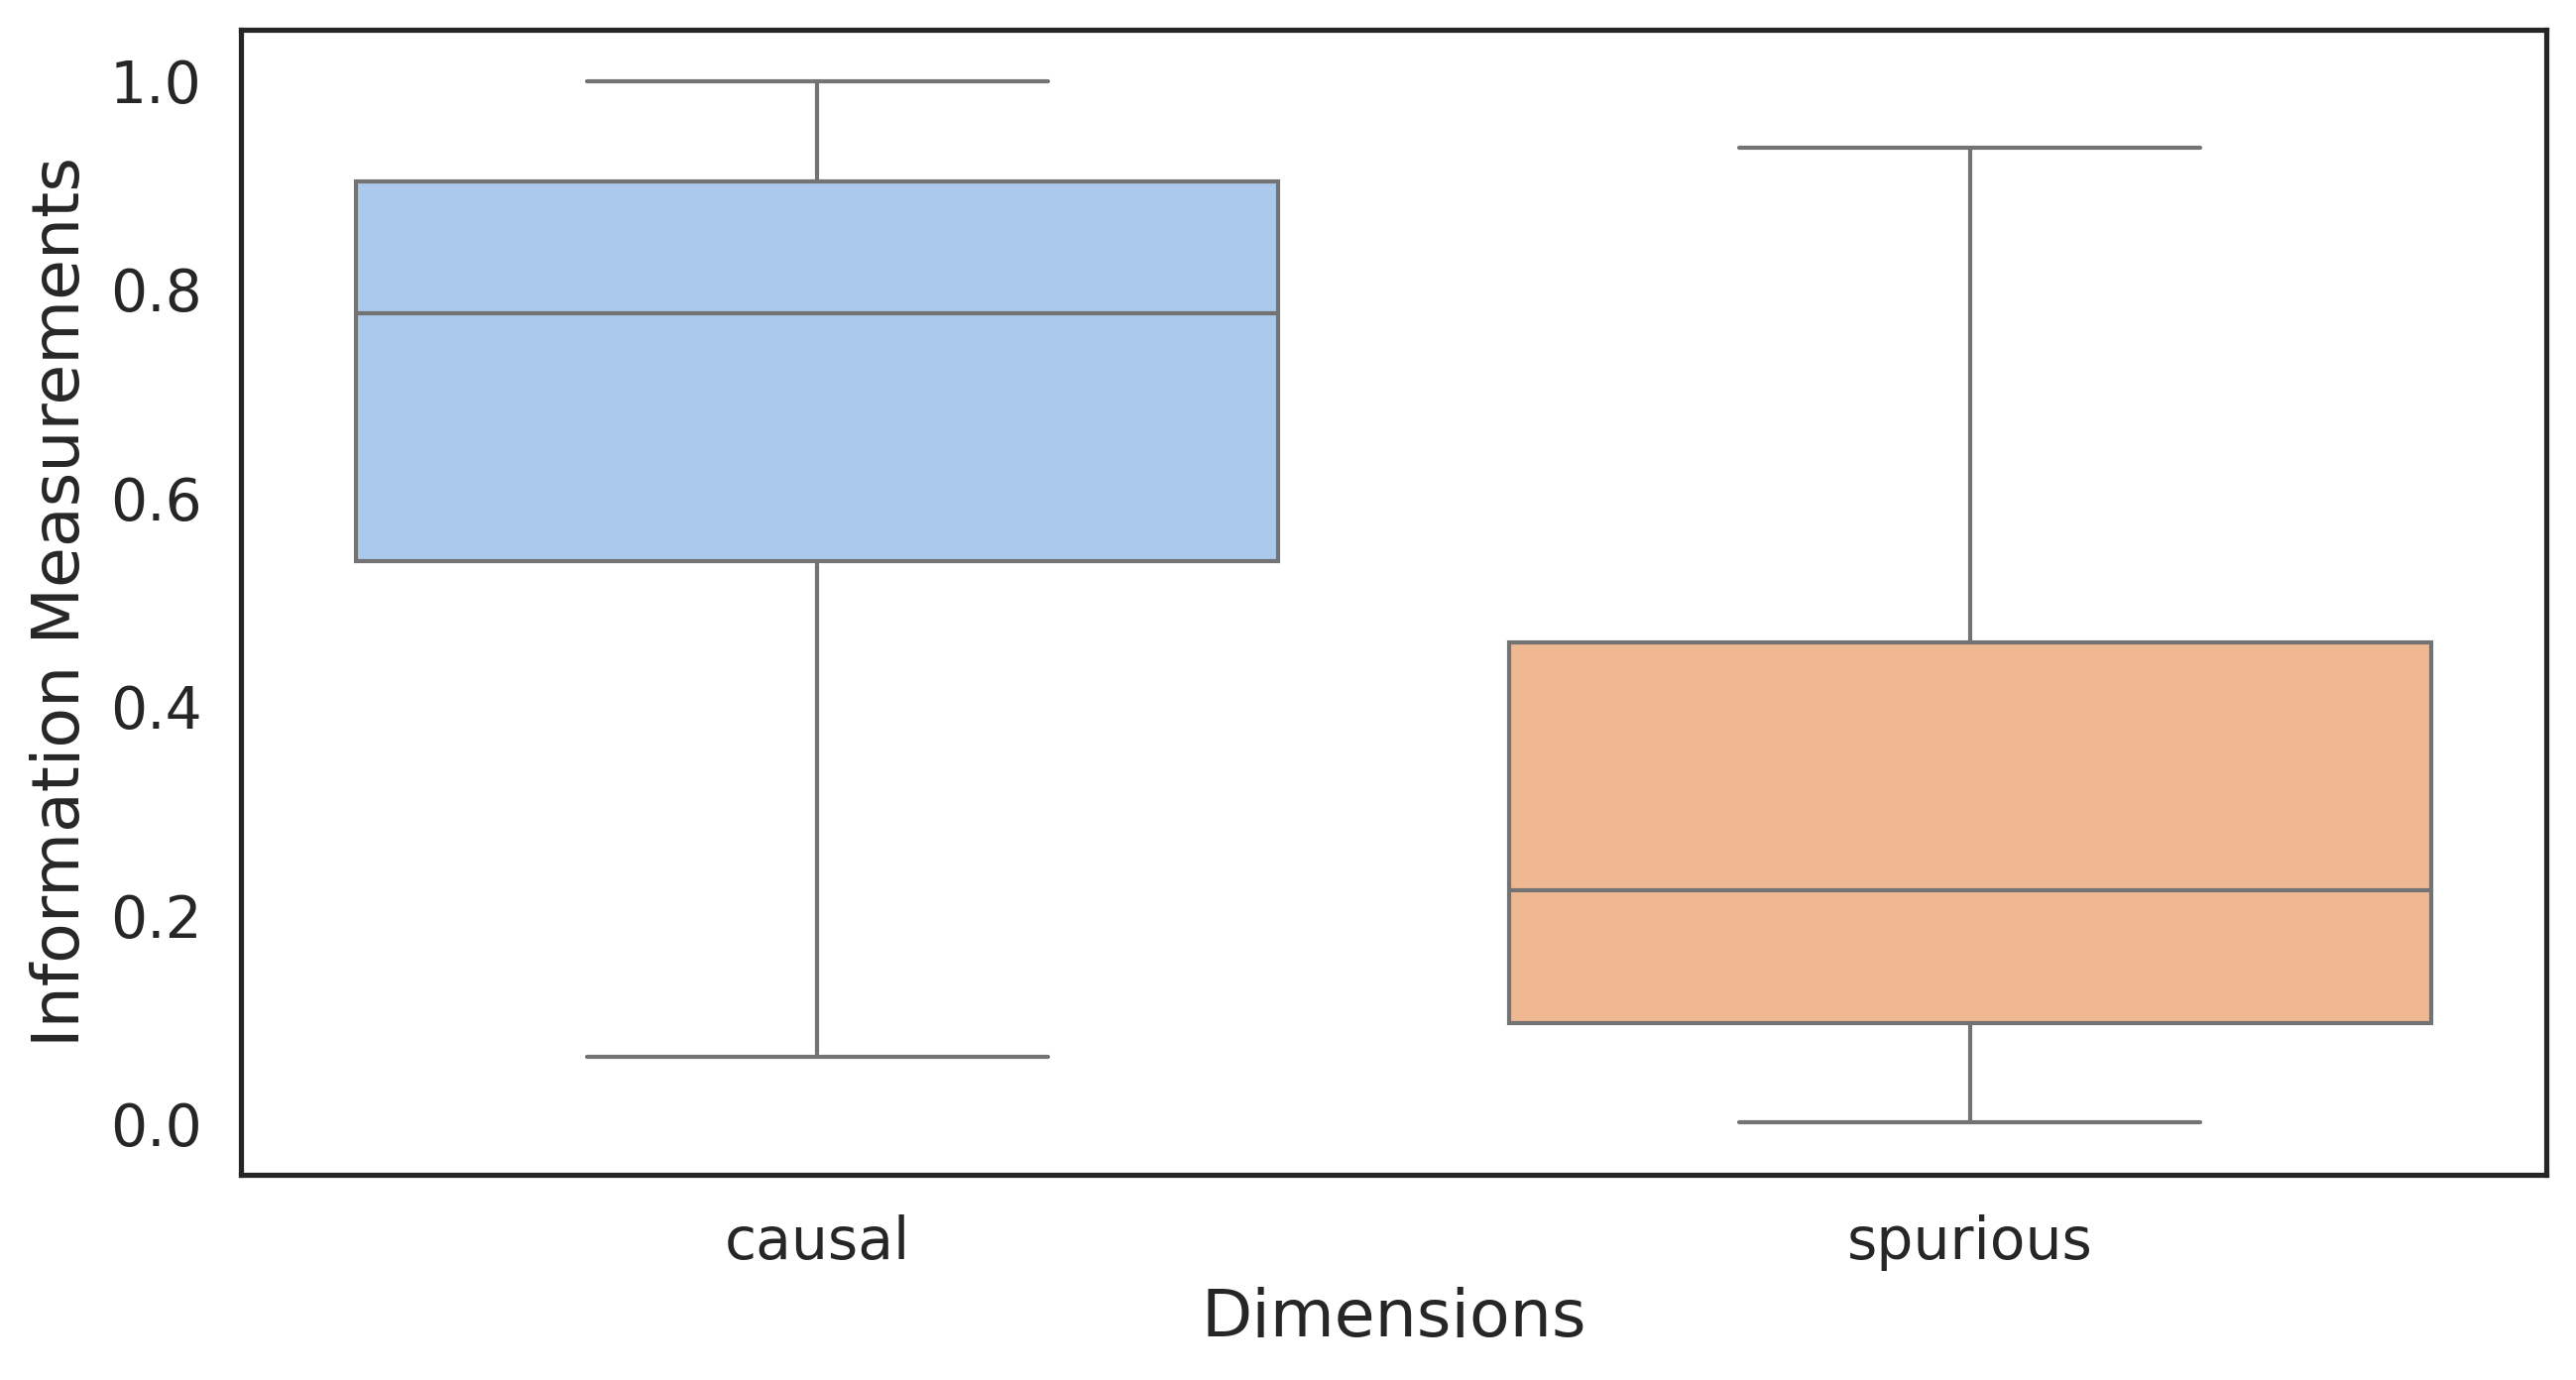

(            0         1         2         3         4         5         6  \
 0    0.490880  0.307667  0.006788  0.046713  0.023150  0.060010  0.022715   
 1    0.271371  0.586589  0.007083  0.017069  0.006886  0.033169  0.005213   
 2    0.137355  0.726735  0.024560  0.035258  0.008943  0.002612  0.000808   
 3    0.693573  0.164123  0.004589  0.026349  0.009502  0.056385  0.006379   
 4    0.119563  0.658189  0.025053  0.095344  0.005562  0.004343  0.000766   
 ..        ...       ...       ...       ...       ...       ...       ...   
 195  0.468126  0.010783  0.074487  0.035272  0.084719  0.160081  0.013601   
 196  0.219003  0.099201  0.127269  0.014876  0.122657  0.202516  0.003111   
 197  0.302682  0.052102  0.057741  0.045482  0.111329  0.196043  0.032698   
 198  0.481469  0.041554  0.067413  0.054515  0.068185  0.137188  0.023968   
 199  0.286295  0.348240  0.005486  0.017031  0.049375  0.113826  0.013567   
 
             7         8         9  
 0    0.004838  0.027188 

In [6]:
topk = 20
layer2_vars = adata.var_names[adata.var["layer"] == "layer2"]
df_layer1 = df_step1.loc[layer1_vars]
topk_indices = df_layer1["weight"].values.argsort()[-topk:]
X_down = adata.obsm["layer1"][:, topk_indices]

adata_step2 = sc.AnnData(
    X=adata.obsm["layer2"],
    obs=adata.obs.copy(),
    var=adata.var.loc[layer2_vars].copy(),
    obsm={"X_down": X_down}
)

model_2L = CauTrigger2L(
    adata_step2,
    n_causal=2,
    n_latent=10,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=True,
    init_thresh=0.4,
)

model_2L.train(max_epochs=200, stage_training=True, weight_scheme="sim")
df_step2, _ = model_2L.get_up_feature_weights(method='SHAP', normalize=False, sort_by_weight=True)
df_step2 = df_step2.loc[layer2_vars]

model_2L.compute_information_flow(save_fig=True, skip_single_info=False, save_dir=output_dir)


### Layer 2 latent space visualization

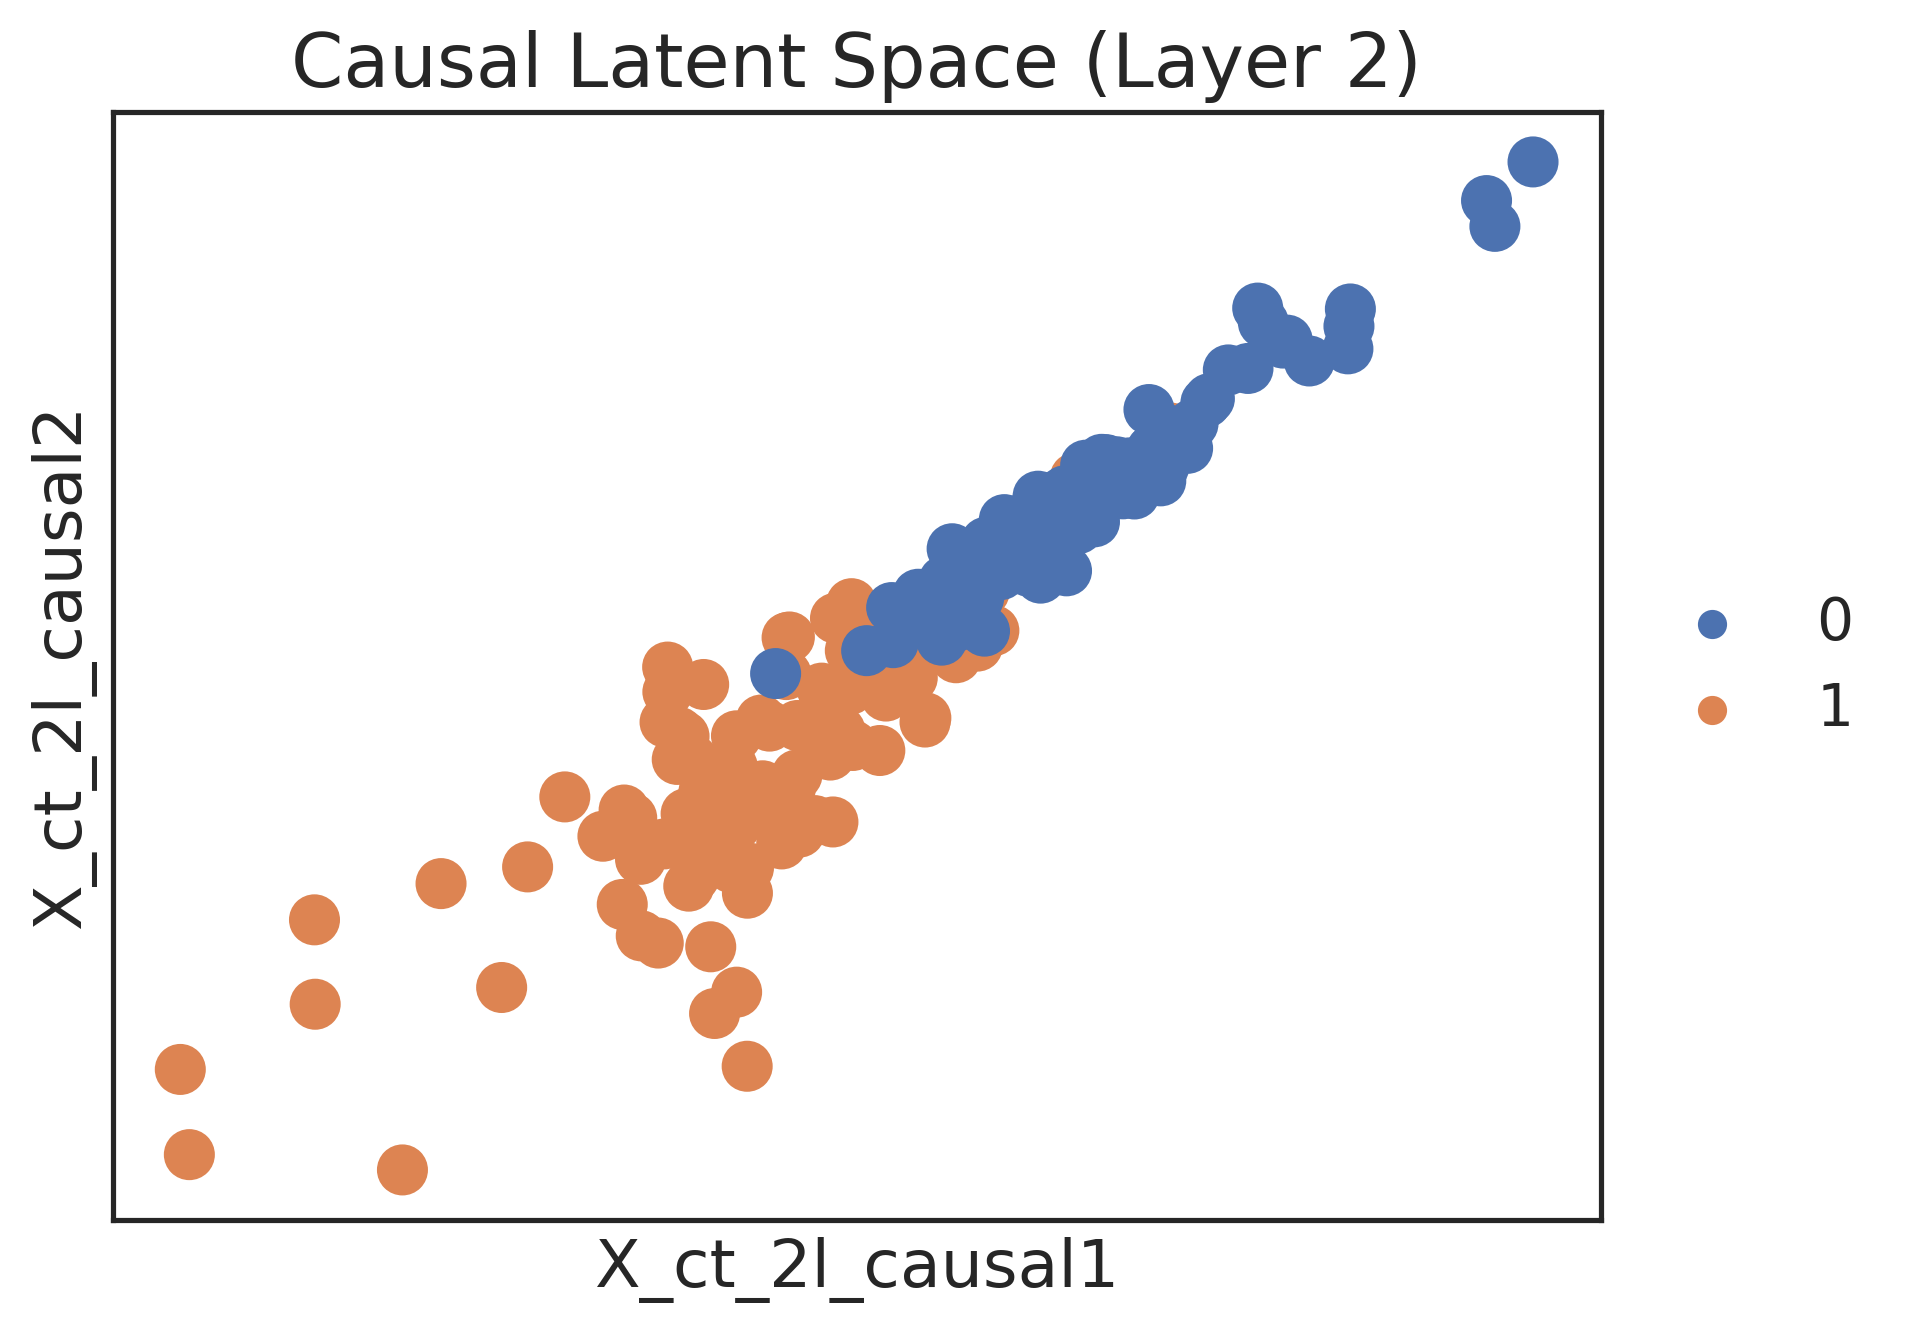

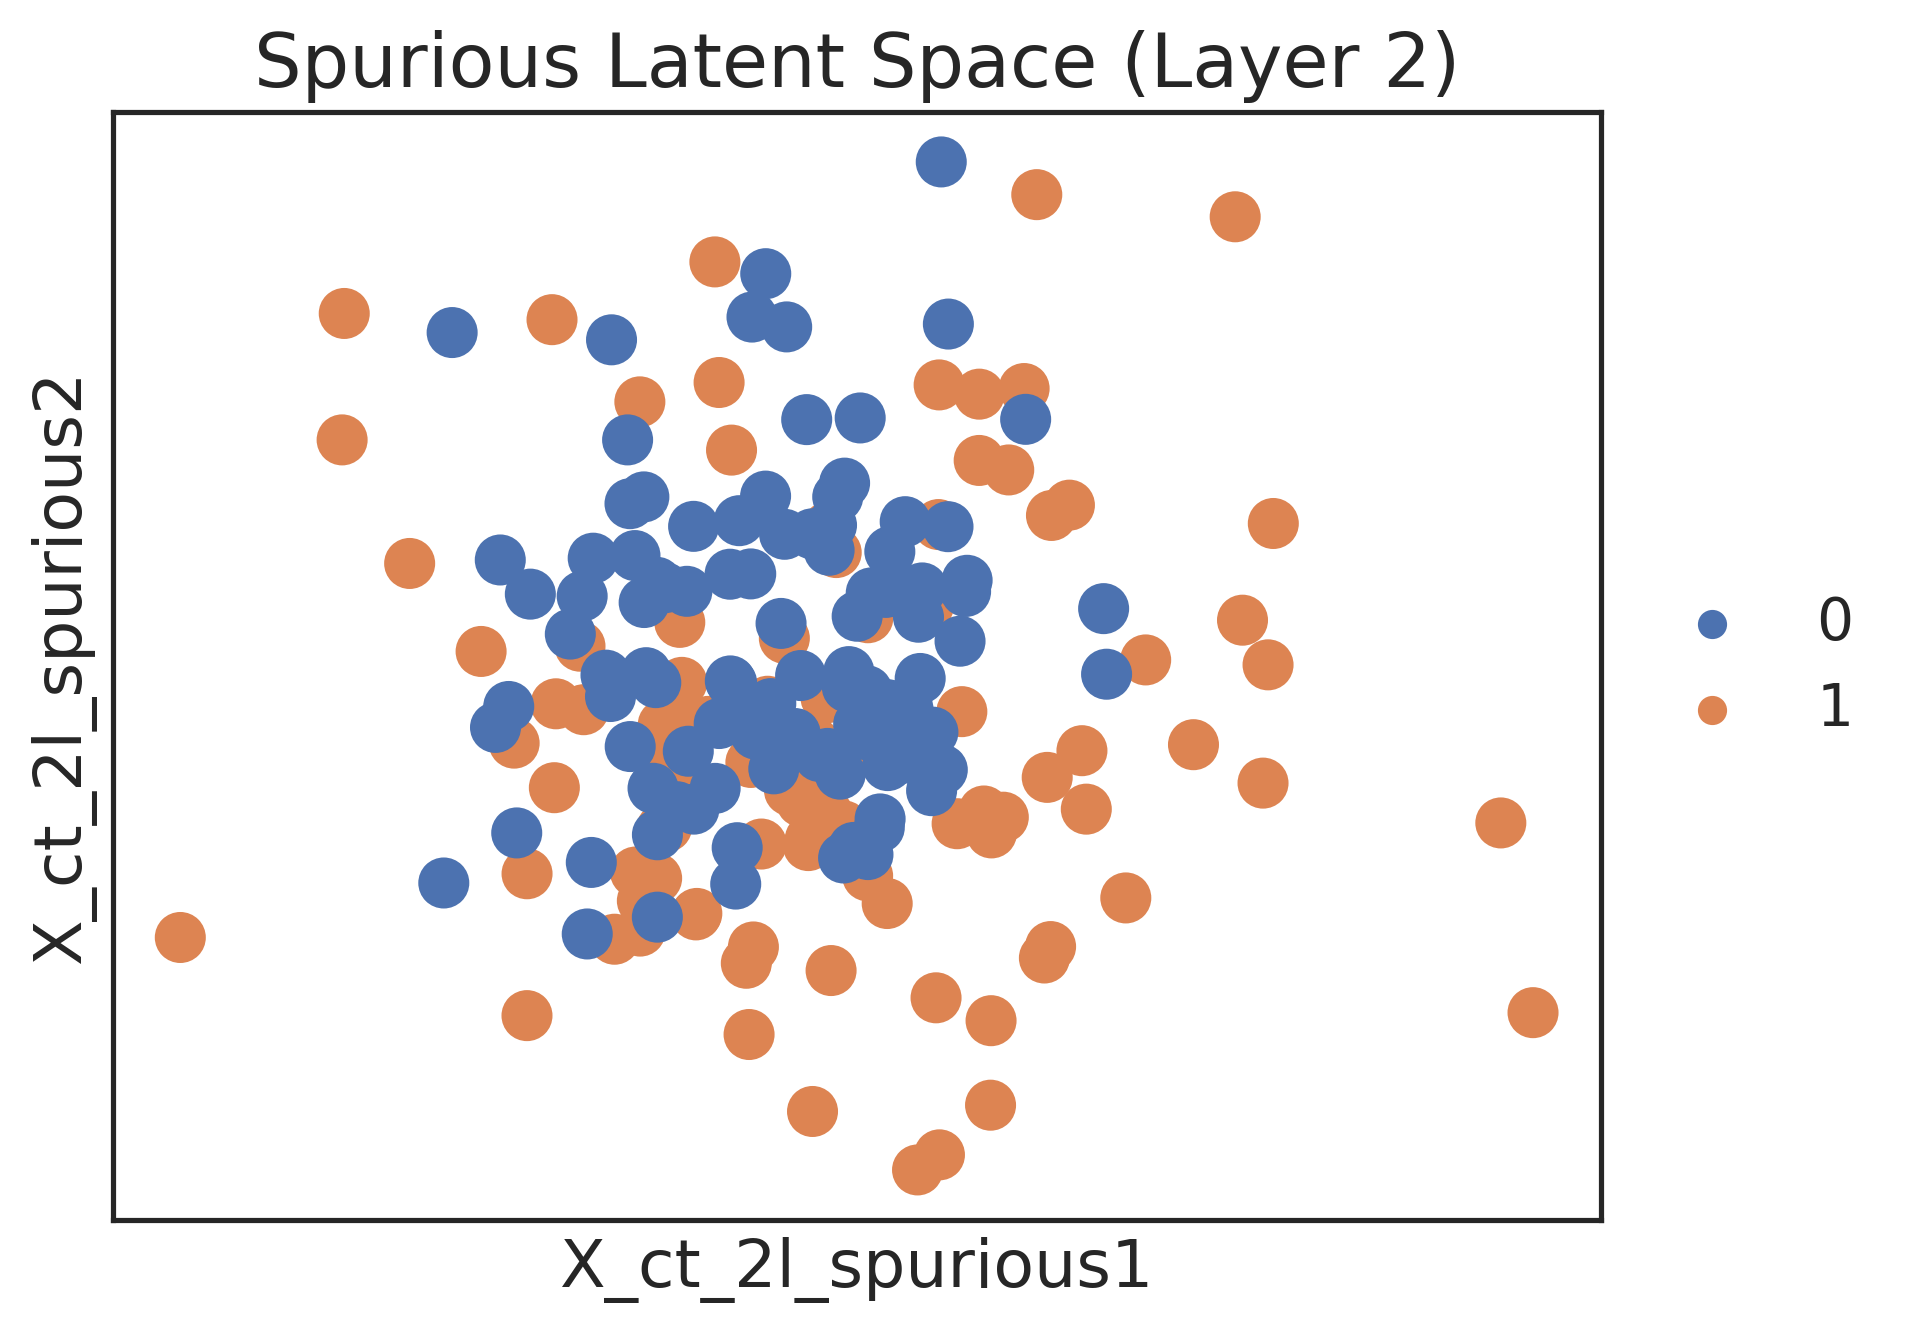

In [7]:
adata_step2.obsm['X_ct_2l_causal'] = model_2L.get_model_output()['latent'][:, :2]
adata_step2.obsm['X_ct_2l_spurious'] = model_2L.get_model_output()['latent'][:, -2:]
adata_step2.obs.labels = adata_step2.obs['labels'].astype(str)

sc.pl.embedding(
    adata_step2, basis='X_ct_2l_causal', color='labels',
    title='Causal Latent Space (Layer 2)', show=True
)

sc.pl.embedding(
    adata_step2, basis='X_ct_2l_spurious', color='labels',
    title='Spurious Latent Space (Layer 2)', show=True
)


## 6. Feature weight comparison across layers

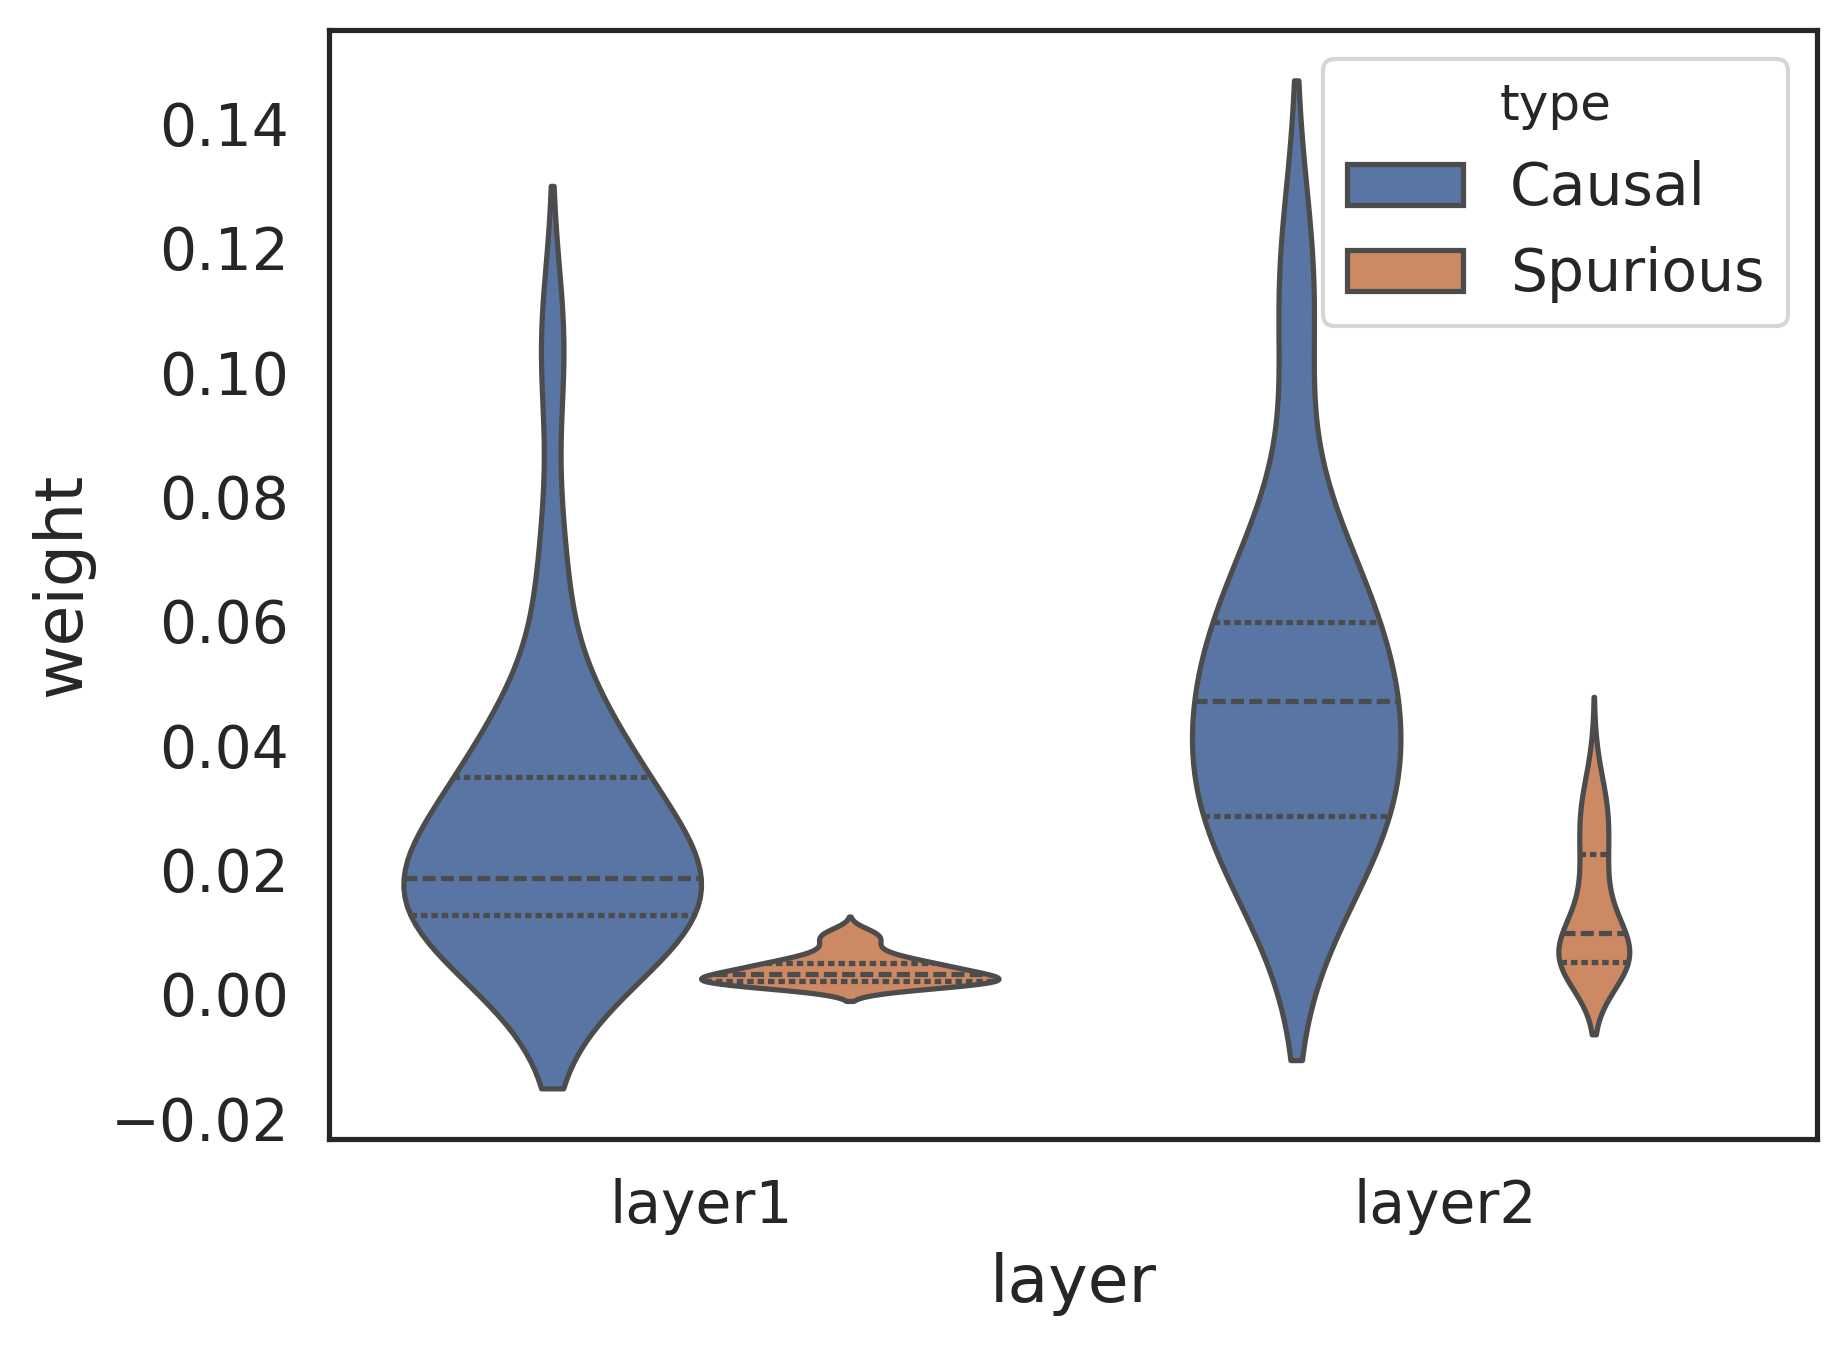

In [8]:
df = pd.DataFrame({
    'weight': np.concatenate([df_step1['weight'].values, df_step2['weight'].values]),
    'type' : ['Causal'] * 20 + ['Spurious'] * 80 + ['Causal'] * 10 + ['Spurious'] * 40,
    'layer': ['layer1'] * (20 + 80) + ['layer2'] * (10 + 40),
})

sns.violinplot(
    data=df,
    x="layer",
    y='weight',
    hue="type",
    inner="quartile"
)
plt.show()